# Analyse the tracks

In [7]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
from lmfit import Model,Parameter,Parameters
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
import os
from functions import plot_preprocessed_dist,plot_track_characteristics,mmsd_plot,cutoff_function,msd
%matplotlib inline
%reload_ext autoreload

In [57]:
files = ["Data/SM1_WNT/sm1_wnt_ld400.csv","Data/SM2_WNT/sm2_wnt_ld400.csv","Data/SM3_WNT/sm3_wnt_ld400.csv","Data/SM4_WNT/sm4_wnt_ld400.csv","Data/SM5_WNT/sm5_wnt_ld400.csv","Data/SM6_WNT/sm6_wnt_ld400.csv","Data/SM7_WNT/sm7_wnt_ld400.csv","Data/SM8_WNT/sm8_wnt_ld400.csv","Data/SM10_WNT/sm10_wnt_ld400.csv"]
#files = ["Data/SM1/sm1_ld400.csv","Data/SM2/sm2_ld400.csv","Data/SM3/sm3_ld400.csv","Data/SM4/sm4_ld400.csv","Data/SM5/sm5_ld400.csv","Data/SM6/sm6_ld400.csv","Data/SM7/sm7_ld400.csv","Data/SM8/sm8_ld400.csv","Data/SM9/sm9_ld400.csv","Data/SM10/sm10_ld400.csv"]

#files = ["Data/SM1_WNT/sm1_wnt_roi.csv","Data/SM2_WNT/sm2_wnt_roi.csv","Data/SM3_WNT/sm3_wnt_roi.csv"]
#files = ["Data/sm1.csv","Data/sm2.csv","Data/sm3.csv","Data/sm4.csv","Data/sm5.csv","Data/sm6.csv","Data/sm7.csv","Data/sm8.csv","Data/sm9.csv","Data/sm10.csv","Data/sm11.csv","Data/sm13.csv"]
#files = ["Data/sm1_wnt.csv","Data/sm2_wnt.csv","Data/sm3_wnt.csv","Data/sm4_wnt.csv","Data/sm5_wnt.csv","Data/sm6_wnt.csv","Data/sm7_wnt.csv","Data/sm8_wnt.csv","Data/sm10_wnt.csv","Data/sm11_wnt.csv"]
#Experimental parameters:
dt = 0.05  #time step
minframe = 8
maxframe = 100

frame_alldata = []
minalpha = 1.0E-03
minD = 1.0E-04
maxD = 4
maxalpha = 3

msd_model = Model(msd)
params = Parameters()
params['alpha']   = Parameter(name='alpha', value=1.0, min=minalpha,max=maxalpha)
params['D']   = Parameter(name='D', value=0.1, min=minD,max=maxD)

alphaD = []
rhoens_alltracks = []
reduced_linear_data = []
INDEX = []


total_tracks=0
anomalous_percentage=0

for filename in files:
    folder_name = filename[5:-4]
    output_folder = "Result/"+folder_name

    data = pd.read_csv(filename) 
    tracklist = data.TRACK_ID.unique()  #list of track ID in data

    for tid in tracklist:

        trackid = data["TRACK_ID"] == tid
        x = data[trackid]["POSITION_X"].to_numpy()   #x associated to track 'tid'
        y = data[trackid]["POSITION_Y"].to_numpy()   #y associated to track 'tid'
        intensity = data[trackid]["MEAN_INTENSITY"].to_numpy()

        frame_alldata.append(len(x))

        rhon = []#list of rho_n for a given track
        if len(x)<maxframe and len(x)>minframe:
            for n in range(1,len(x)):             #for each n = each time lag
                s = 0
                for i in range(0,len(x)-n):
                    s+=(x[n+i] - x[i])**2 + (y[n+i] - y[i])**2
                rhon.append(1/(len(x)-n)*s)

            N = len(rhon)+1
            t = [n*dt for n in np.linspace(1,N-1,N-1)]

            nbrpts = int(0.3*N)
            result = msd_model.fit(rhon[:nbrpts+1], params, t=t[:nbrpts+1])

            #print(len(rhoens_alltracks))
            #plt.plot(rhon)
            #plt.plot(result.best_fit)
            #plt.show()
            
            s=0
            for p in range(0,len(x)-1):
                s+= np.sqrt((x[p+1]-x[p])**2+(y[p+1]-y[p])**2)
            confinement_ratio = np.sqrt((x[-1]-x[0])**2+(y[-1]-y[0])**2)/s
            
            alpha = result.params['alpha'].value
            D = result.params['D'].value
            rsquare = 1 - result.residual.var() / np.var(rhon[:nbrpts+1])
            
            #nuam = 0.01*minalpha
            #nuap = 0.01*maxalpha
            #nuDm = 0.01*minD
            #nuDp = 0.01*maxD

            #if minalpha+nuam<alpha<maxalpha-nuap and minD+nuDm<D<maxD-nuDp and confinement_ratio!=0.0:
            if rsquare > 0.8 and confinement_ratio!=0.0:
                rhoens_alltracks.append(rhon)
                plot_element = [alpha,D,confinement_ratio,len(x)] #len(x)
                alphaD.append(plot_element)
                INDEX.append([x,y])

            else:
                anomalous_percentage+=1

            total_tracks+=1

print(len(rhoens_alltracks),np.shape(alphaD))
print("Percentage of dismissed MSDs due to bad fit : ",anomalous_percentage/total_tracks*100," %")

###########################################################
####################COMPUTE K MEAN ########################
###########################################################

#from sklearn import cluster, datasets
#from mpl_toolkits.mplot3d import Axes3D
#from sklearn.cluster import KMeans
#from sklearn import datasets
#from sklearn import preprocessing

#k_means = cluster.KMeans(n_clusters=3)
alphaD = np.array(alphaD)

#FEATURES = np.copy(alphaD)

#pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
#PROCESSED_FEATURES = pt.fit_transform(FEATURES[:,:3]) #do not use track length for the clustering
#PROCESSED_FEATURES = preprocessing.minmax_scale(PROCESSED_FEATURES)

#k_means.fit(PROCESSED_FEATURES)
#labels = k_means.labels_

#colors = ['g', "crimson", 'turquoise',"pink",'lightcoral','orange','blue']
#color_array = []
#for k in range(len(labels.astype(np.int))):
#    color_index = labels.astype(np.int)[k]
#    color_array.append(colors[color_index])

####PLOT PROCESSED DISTRIBUTIONS#########################
#plot_preprocessed_dist(PROCESSED_FEATURES,FEATURES)

#########################################################
############## END OF K-MEAN ############################
#########################################################


#plot_track_characteristics(dt,FEATURES,rhoens_alltracks,frame_alldata,color_array,minframe,maxframe,INDEX)

#alpha,diff,conf,length_track = zip(*FEATURES)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in double_scalars


2266 (2266, 4)
Percentage of dismissed MSDs due to bad fit :  49.21559838637382  %


In [58]:
DATA_WNT = alphaD

In [56]:
DATA = alphaD

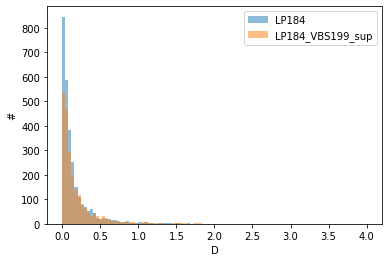

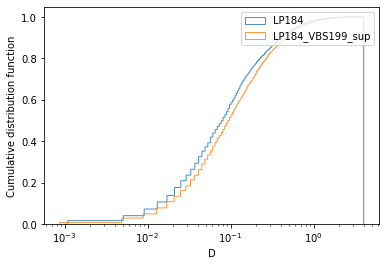

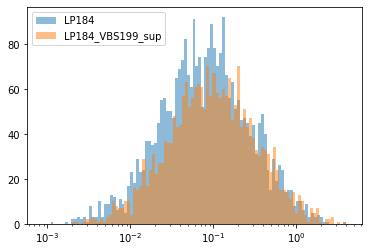

2880
2266
0.07149161518093557 1.8535574432382877e-05


In [75]:
from scipy.stats import ks_2samp

import seaborn as sns
from scipy.stats import mannwhitneyu
darray_wnt = DATA_WNT[:,1]
darray = DATA[:,1]

np.savetxt("D_LP184.txt",darray)
np.savetxt('D_LP184_VBS199_sup',darray_wnt)


plt.hist(darray,bins=100,alpha=0.5,label="LP184")
plt.hist(darray_wnt,bins=100,alpha=0.5,label="LP184_VBS199_sup")
plt.xlabel('D')
plt.ylabel('#')
plt.legend()
plt.show()

plt.hist(darray,1000, density=True, cumulative=True, histtype='step', alpha=0.8,label="LP184")
plt.hist(darray_wnt,1000, density=True, cumulative=True, histtype='step', alpha=0.8,label="LP184_VBS199_sup")
plt.xscale('log')
plt.xlabel('D')
plt.ylabel('Cumulative distribution function')
plt.legend()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

def plot_loghist(x, bins,labels):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins,label=labels,alpha=0.5)
    plt.xscale('log')

plot_loghist(darray, 100,'LP184')
plot_loghist(darray_wnt,100,'LP184_VBS199_sup')
plt.legend()
plt.show()

print(len(darray))
print(len(darray_wnt))



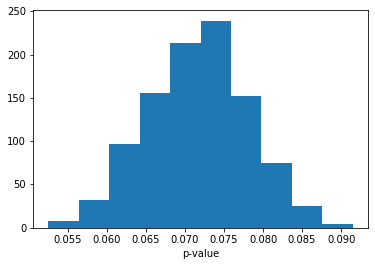

In [89]:
import random 
def partition(list_in, n):
    random.shuffle(list_in)
    return([list_in[i::n] for i in range(n)])

batchsize = min([len(darray),len(darray_wnt)])
stat_array = []

for k in range(1000):
    test1 = partition(darray,1)[0]
    test2 = partition(darray_wnt,1)[0]

    dred = test1[:2000]
    dredwnt = test2[:2000]
    stat, pvalue = ks_2samp(dred,dredwnt)
    stat_array.append(stat)
    

plt.hist(stat_array)
plt.xlabel('p-value')
plt.show()

# Other stuff




In [142]:
traj1,color1 = INDEX,color_array
print(np.shape(traj1))

(454, 2)


In [146]:
traj2,color2 = INDEX,color_array
print(np.shape(traj2))

(47, 2)


In [163]:
for t1 in traj1:
    for t2 in traj2:
        intersect = np.intersect1d(t1[0],t2[0])
        if len(intersect)!=0:
            print(t1[0],'\n',t2[0],"\n Track length difference = ",len(t1[0])-len(t2[0]),'\n')

[12.185 12.544 12.627 12.659 12.505 12.363 12.418 12.396 12.392 12.482
 12.442 12.484 12.403 12.363 12.381 12.423 12.48  12.425 12.489 12.347
 12.406] 
 [12.418 12.396 12.392 12.482 12.442 12.484 12.403 12.363 12.381 12.423
 12.48  12.425 12.489] 
 Track length difference =  8 

[58.3   58.415 58.362 58.518 58.31  58.279 58.467 58.347 58.371 58.28
 58.389 58.474 58.358 58.366 58.287 58.343 58.311] 
 [58.404 58.397 58.342 58.382 58.305 58.324 58.278 58.366 58.406 58.31
 58.326] 
 Track length difference =  6 

[58.3   58.415 58.362 58.518 58.31  58.279 58.467 58.347 58.371 58.28
 58.389 58.474 58.358 58.366 58.287 58.343 58.311] 
 [58.437 58.317 58.363 58.312 58.354 58.372 58.316 58.335 58.358 58.405
 58.364 58.342] 
 Track length difference =  5 

[52.633 52.851 52.886 52.851 52.91  53.057 53.111 52.951 52.754] 
 [52.924 52.901 53.008 52.927 52.922 52.904 52.892 52.932 52.975 52.961
 52.975 52.886 52.925] 
 Track length difference =  -4 

[52.633 52.851 52.886 52.851 52.91  53.057 53.1

[40.919 41.061 41.098 41.008 40.955 40.998 40.892 41.011 41.131 41.054
 41.075 41.014] 
 [41.097 41.093 41.027 41.03  40.982 40.986 41.107 41.097 40.998 41.038
 41.083] 
 Track length difference =  1 

[28.624 28.639 28.692 28.702 28.749 28.673 28.694 28.645 28.703 28.726
 28.58  28.516 28.647 28.75  28.76  28.819] 
 [28.624 28.639 28.692 28.702 28.749 28.673 28.694 28.645 28.703 28.726] 
 Track length difference =  6 

[28.624 28.639 28.692 28.702 28.749 28.673 28.694 28.645 28.703 28.726
 28.58  28.516 28.647 28.75  28.76  28.819] 
 [28.687 28.723 28.639 28.73  28.795 28.708 28.69  28.589 28.569] 
 Track length difference =  7 

[20.239 20.302 20.354 20.317 20.376 20.328 20.392 20.324 20.301] 
 [20.239 20.302 20.354 20.317 20.376 20.328 20.392 20.324 20.301] 
 Track length difference =  0 

[52.896 52.902 52.883 52.908 52.821 52.937 52.984 52.969 52.935 52.885
 52.897 52.954 52.943 52.891 52.937 52.948 52.987 52.951 53.009 52.954
 52.963] 
 [52.963 52.958 52.998 52.914 52.926 52.903 

[53.178 52.943 52.908 52.945 52.98  52.949 52.899 52.927 52.941 52.959
 52.904 52.918 52.919 52.906 52.962 52.908 52.88  52.942 53.009 52.976
 52.943 52.929 52.944 52.903 53.011 52.938] 
 [53.043 53.016 52.975 52.939 52.925 52.912 53.047 52.915 52.925 52.89
 52.968 52.969 52.904 52.988 52.976] 
 Track length difference =  11 

[53.178 52.943 52.908 52.945 52.98  52.949 52.899 52.927 52.941 52.959
 52.904 52.918 52.919 52.906 52.962 52.908 52.88  52.942 53.009 52.976
 52.943 52.929 52.944 52.903 53.011 52.938] 
 [52.936 52.918 52.905 52.891 52.947 52.988 52.947 52.996 52.914 52.952
 52.919 52.924 52.974 52.919 52.941 53.    52.932 52.932] 
 Track length difference =  8 

[52.589 52.754 52.539 52.714 52.436 52.539 52.407 52.68  52.607 52.475
 52.538 52.561 52.453 52.636] 
 [52.515 52.591 52.563 52.525 52.418 52.537 52.581 52.607 52.588 52.52
 52.501 52.554] 
 Track length difference =  2 

[42.483 42.497 42.418 42.269 42.429 42.291 42.403 42.436 42.35  42.337
 42.556 42.397 42.446 42.464

(512, 512)


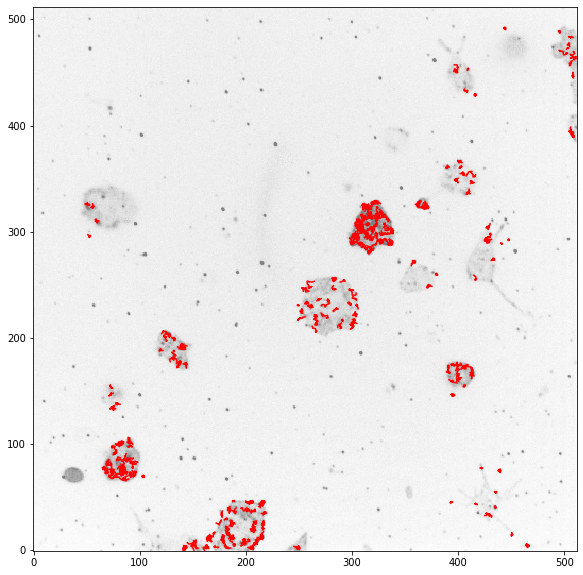

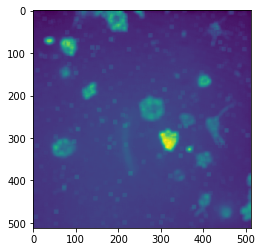

[[24 24 24 ... 13 14 13]
 [24 24 24 ... 13 14 13]
 [23 23 24 ... 14 15 14]
 ...
 [45 45 45 ... 36 36 37]
 [45 45 45 ... 36 36 37]
 [45 45 45 ... 36 36 36]] [[ 0  4 10 ...  3  7  0]
 [15 21 16 ...  6 13 12]
 [14 22 11 ... 14 15 16]
 ...
 [49 45 38 ... 29 28 34]
 [41 45 41 ... 46 36 34]
 [36 50 50 ... 32 32 42]]


In [139]:
import cv2

imagepath = "Data/SM1/"

fig = plt.figure(figsize=(10,10))

image = plt.imread(imagepath+'sm1.jpg')
print(np.shape(image))
plt.imshow(image,cmap='Greys',alpha=0.5)

image_blur = cv2.blur(image,(10,10))

clustercolor = np.unique(color1)
for color in clustercolor:
    for k in range(len(color1)):
        if color1[k]==color:
            x = [xx/0.133 for xx in traj1[k][0]]
            y = [yy/0.133 for yy in traj1[k][1]]
            line = int(y[0])
            column = int(x[0])
            if image_blur[line][column]>1:
                plt.plot(x,y,c='r')
            
#for color in clustercolor:
#    for k in range(len(color2)):
#        if color1[k]==color:            
#            x = [xx/0.133 for xx in traj2[k][0]]
#            y = [yy/0.133 for yy in traj2[k][1]]
#            plt.plot(x,y,c='r')
plt.gca().invert_yaxis()
plt.savefig(imagepath+'tracks_on_image_shortink.png')
plt.show()

plt.imshow(image_blur)
plt.show()

print(image_blur,image)

# Select a cluster to perform linear MSD analysis

In [11]:
clustercolor = input('Over which cluster do you want to perform a linear MSD analysis? Options: g, k, crimson, turquoise, pink, lightcoral...')

linear_data = []

for k in range(len(color_array)):
    if color_array[k]==clustercolor:
        linear_data.append(rhoens_alltracks[k][:])

reduced_linear_data = np.array(linear_data)

with open('filtered_msd.txt','w') as f:
    for listk in reduced_linear_data:
        for n in range(len(listk)):
            f.write(str(listk[n])+' ')
        f.write('\n')

Over which cluster do you want to perform a linear MSD analysis? Options: g, k, crimson, turquoise, pink, lightcoral...turquoise


60
Use all tracks to compute an ensemble MSD and its associated variance...
Plot ensemble MSD...


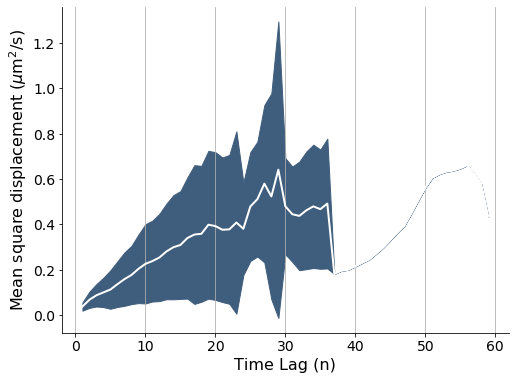

After how many time steps n do you want to cut the data? 23
You have set the cutoff to a time lag of  23  steps...
Initial run to determine the best theoretical values for D and sigma.
It is estimated that the lowest error will be for a number of fitting points P =  21  for which the relative error sigma/b =  0.3507445865979711
D =  0.0924
It is estimated that the lowest error will be when the number of fitting points P =  3  for which the relative error sigmaa/a =  0.04383391387740993
sigma =  0.0605
Second run with accurate values for D and sigma.
D =  0.0924
sigma =  0.0605
Done.


In [14]:
from sklearn.linear_model import LinearRegression
from functions import *
import os


data,N_array = MSD_tracks_from_file("filtered_msd.txt")

N = np.shape(data)[1]+1
print(N)
D= 0.2
sigma=0.3
T = N*dt
epsilon = 4*sigma**2
alpha = 4*D*dt

##############" PLOT ALL DATA MSD #################
print("Use all tracks to compute an ensemble MSD and its associated variance...")
msd,var = average(data)
timelagn = np.linspace(1,N-1,N-1)
timelag = [n*dt for n in timelagn]


print("Plot ensemble MSD...")
mmsd_plot(timelagn,msd,var)

### SELECT CUTOFF #################################

data,timelag,msd,var,cutoff = cutoff_function(dt,N,data,timelag,msd,var)

##### PLOT MSD AND VARIANCE WITH CUTOFF ###############

for z in range(2):
    if z==0:
        print("Initial run to determine the best theoretical values for D and sigma.")
    if z==1:
        print("Second run with accurate values for D and sigma.")
    theory_msd = [4*D*n + epsilon for n in timelag]
    theory_variance = THEORETICAL_VARIANCE_2(N_array,sigma,D,dt)[:cutoff]
    cov = COVARIANCE(data,cutoff)
    theory_covariance = THEORETICAL_COVARIANCE_2(N_array,sigma,D,dt,cutoff)#[:cutoff,:cutoff]

    ###########################################
    ############### ERROR SLOPE ###############
    Pmin_array = [int(p) for p in np.linspace(2,cutoff-2,cutoff-3)]
    sigmab_theory = []
    sigmab_exp_th = []
    sigmab_exp    = []

    for p in Pmin_array:
        sigmab_theory.append(NormMSDSlopeError(N,sigma,D,dt,p))
        sigmab_exp_th.append(NormMSDSlopeError_exp(N,sigma,D,dt,theory_variance,theory_covariance,p))
        sigmab_exp.append(NormMSDSlopeError_exp(N,sigma,D,dt,var,cov,p))

    min_y = min(sigmab_exp) 
    min_x = Pmin_array[sigmab_exp.index(min_y)]

    if z==0:
        print("It is estimated that the lowest error will be for a number of fitting points P = ",min_x," for which the relative error sigma/b = ",min_y)


    timelag = np.array(timelag)
    x = timelag.reshape((-1, 1))
    y = msd
    ctffb = int(min_x)
    model = LinearRegression().fit(x[:ctffb], y[:ctffb])
    r_sq = model.score(x[:ctffb], y[:ctffb])
    fit_b = model.predict(x)

    Dvalue = round(model.coef_[0]/4,4)
    print("D = ",Dvalue)
    Dvalue_error = round(min_y*model.coef_[0]/4,4)


    ###########################################
    ############### ERROR INTERCEPT ###############

    Pmin_array = [int(p) for p in np.linspace(2,cutoff-2,cutoff-3)]
    sigmaa_theory = []
    sigmaa_exp_th = []
    sigmaa_exp    = []
    for p in Pmin_array:
        sigmaa_theory.append(NormMSDInterceptError(N,sigma,D,dt,p))
        sigmaa_exp_th.append(NormMSDInterceptError_exp(N,sigma,D,dt,theory_variance,theory_covariance,p))
        sigmaa_exp.append(NormMSDInterceptError_exp(N,sigma,D,dt,var,cov,p))

    min_y = min(sigmaa_exp) 
    min_x = Pmin_array[sigmaa_exp.index(min_y)]

    if z==0:
        print("It is estimated that the lowest error will be when the number of fitting points P = ",min_x," for which the relative error sigmaa/a = ",min_y)

    timelag = np.array(timelag)
    xa = timelag.reshape((-1, 1))
    ya = msd
    ctffa = int(min_x)
    model = LinearRegression().fit(x[:ctffa], y[:ctffa])
    r_sq = model.score(x[:ctffa], y[:ctffa])
    fit_a = model.predict(x)

    loc_sigma = round(np.sqrt(model.intercept_/4),4)
    loc_sigma_error = round(min_y/2*model.intercept_,4)
    print("sigma = ",loc_sigma)
    
    D = Dvalue
    if np.isnan(loc_sigma)==True:
        print("sigma is nan. Replace with value close to zero.")
        sigma = 0.0000001
    else:
        sigma = loc_sigma

    epsilon = 4*sigma**2
    alpha = 4*D*dt
    if z==1:
        print("Done.")

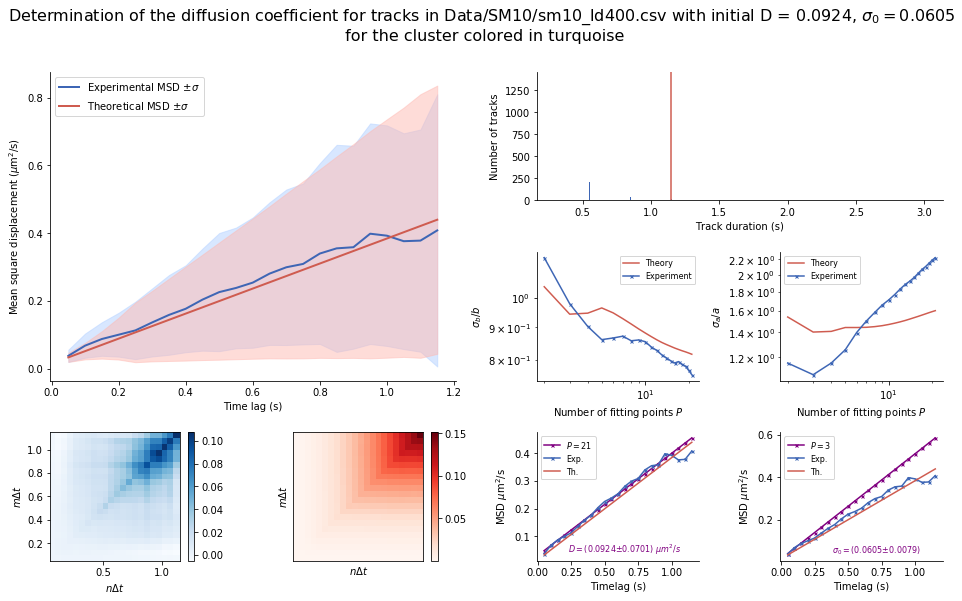

In [15]:
############## GLOBAL PLOT ###################################"

fig = plt.figure(figsize=(16, 9))
grid = plt.GridSpec(3, 4, hspace=0.4, wspace=0.5)
msd_plot = fig.add_subplot(grid[0:2,0:2])
cov_exp = fig.add_subplot(grid[2,0])
cov_th  = fig.add_subplot(grid[2,1])
hist = fig.add_subplot(grid[0,2:4])
sigmab_err = fig.add_subplot(grid[1,2])
sigmaa_err = fig.add_subplot(grid[1,3])
D_plot = fig.add_subplot(grid[2,2])
loc_unc_plot = fig.add_subplot(grid[2,3])

cexp = "#3e66b5"
cth  = "#cf5c50"
msize = 3.0

######## MSD SUBPLOT #######################
msd_plot.spines["top"].set_visible(False)  
msd_plot.spines["right"].set_visible(False)
msd_plot.get_xaxis().tick_bottom()  
msd_plot.get_yaxis().tick_left()
msd_plot.fill_between(timelag,[a - np.sqrt(b) for a,b in zip(msd,var)],[a + np.sqrt(b) for a,b in zip(msd,var)], color="#b3d1ff",alpha=0.5)
msd_plot.fill_between(timelag,[a - np.sqrt(b) for a,b in zip(theory_msd,theory_variance)],[a + np.sqrt(b) for a,b in zip(theory_msd,theory_variance)], color="#febab3",alpha=0.5) 
msd_plot.plot(timelag,msd,color=cexp, lw=2,label="Experimental MSD $\pm \sigma $")
msd_plot.plot(timelag,theory_msd,color=cth, lw=2,label="Theoretical MSD $\pm \sigma $")
msd_plot.set_ylabel(r"Mean square displacement ($\mu$m$^2/$s)",fontsize=10)
msd_plot.set_xlabel('Time lag (s)',fontsize=10)
msd_plot.legend(loc="upper left",fontsize=10)

########## HISTOGRAM ########################"

hist.spines["top"].set_visible(False)  
hist.spines["right"].set_visible(False)
hist.get_xaxis().tick_bottom()  
hist.get_yaxis().tick_left()
hist_array = [n*dt for n in N_array]
hist.hist(hist_array,color=cexp, bins=int(len(N_array)))
hist.axvline(cutoff*dt, 0, max(hist_array),color=cth)
hist.set_xlabel('Track duration (s)',fontsize=10)
hist.set_ylabel('Number of tracks',fontsize=10)

######## COVARIANCE #############################

im1 = cov_exp.pcolormesh(timelag,timelag,cov,cmap="Blues")
cov_exp.set_xlabel(r'$n \Delta t$')
cov_exp.set_ylabel(r'$m \Delta t$')
cbar = plt.colorbar(im1,ax=cov_exp)
#plt.title('Map of experimental covariance values')

im2 = cov_th.pcolormesh(timelag,timelag,theory_covariance,cmap="Reds")
#cov_th.colorbar()
cov_th.set_xticks([])
cov_th.set_yticks([])
cov_th.set_xlabel(r'$n \Delta t$')
cov_th.set_ylabel(r'$m \Delta t$')
cbar = plt.colorbar(im2,ax=cov_th)
#cov_th.set_title('Map of theoretical covariance values')


############## ERRORS ###################################
sigmab_err.spines["top"].set_visible(False)  
sigmab_err.spines["right"].set_visible(False)
sigmab_err.get_xaxis().tick_bottom()  
sigmab_err.get_yaxis().tick_left()
sigmab_err.loglog(Pmin_array,sigmab_exp_th,label="Theory",color=cth)
sigmab_err.loglog(Pmin_array,sigmab_exp,"-x",label="Experiment",color=cexp,ms=msize)
sigmab_err.set_xlabel('Number of fitting points $P$')
sigmab_err.set_ylabel(r'$\sigma_b / b$')
sigmab_err.legend(fontsize=8)

sigmaa_err.spines["top"].set_visible(False)  
sigmaa_err.spines["right"].set_visible(False)
sigmaa_err.get_xaxis().tick_bottom()  
sigmaa_err.get_yaxis().tick_left()
sigmaa_err.loglog(Pmin_array,sigmaa_exp_th,label="Theory",color=cth)
#sigmaa_err.loglog(Pmin_array,sigmaa_exp_th,".",label="Control_theory from matrices")
sigmaa_err.loglog(Pmin_array,sigmaa_exp,"-x",label="Experiment",color=cexp,ms=msize)
sigmaa_err.set_xlabel('Number of fitting points $P$')
sigmaa_err.set_ylabel(r'$\sigma_a / a$')
sigmaa_err.legend(fontsize=8)

############" LINEAR FITS ######################################
D_plot.spines["top"].set_visible(False)  
D_plot.spines["right"].set_visible(False)
D_plot.get_xaxis().tick_bottom()  
D_plot.get_yaxis().tick_left()
D_plot.plot(x, fit_b,"-x",label=r'$P = $'+str(ctffb),color="purple",ms=msize)
D_plot.plot(timelag,msd,"-x",label="Exp.",color=cexp,ms=msize)
D_plot.plot(timelag,theory_msd,label="Th.",color=cth)
D_plot.legend(loc="upper left",fontsize=8)
D_plot.set_xlabel('Timelag (s)')
D_plot.set_ylabel(r'MSD $\mu$m$^2/$s')
D_plot.text(max(timelag)/5,max(msd)/10,r'$D = ($'+str(Dvalue)+"$\pm$"+str(Dvalue_error)+") $\mu m^2 / s$",color="purple",fontsize=8)

loc_unc_plot.spines["top"].set_visible(False)  
loc_unc_plot.spines["right"].set_visible(False)
loc_unc_plot.get_xaxis().tick_bottom()  
loc_unc_plot.get_yaxis().tick_left()
loc_unc_plot.plot(x, fit_a,"-x",label=r'$P = $'+str(ctffa),color="purple",ms=msize)
loc_unc_plot.plot(timelag,msd,"x-",label="Exp.",color=cexp,ms=msize)
loc_unc_plot.plot(timelag,theory_msd,label="Th.",color=cth)
loc_unc_plot.legend(loc="upper left",fontsize=8)
loc_unc_plot.set_xlabel('Timelag (s)')
loc_unc_plot.set_ylabel(r'MSD $\mu$m$^2/$s')
loc_unc_plot.text(max(timelag)/3,max(msd)/10,r'$\sigma_0 = ($'+str(loc_sigma)+"$\pm$"+str(loc_sigma_error)+")",color="purple",fontsize=8)

fig.suptitle(r'Determination of the diffusion coefficient for tracks in '+filename+" with initial D = "+str(D)+", $\sigma_0 = $"+str(sigma)+"\n for the cluster colored in "+clustercolor, fontsize=16)
#plt.savefig(output_folder+'/graphs.png')
plt.show()